# <center> **TP1 - Big Data :**
#### <center> **Jean-Pierre Mansour et Iyad Zekhnini :**

In [241]:
import numpy as np
from numpy.typing import ArrayLike
import numba
import matplotlib.pyplot as plt
import matplotlib.patches
import math as Math

In [318]:
@numba.njit()
def f(x : ArrayLike, g : ArrayLike, s : ArrayLike) -> float:
    sum : float = 0

    for i in range(len(s)):
        sum += np.exp(- (x - g[i]).T @ (x - g[i]) / (2 * s[i]**2) )

    return sum

@numba.njit()
def ind_A(x : ArrayLike, g : ArrayLike, s : ArrayLike) -> bool:
    return 2 * (f(x, g, s) > 1/2) - 1

def intens(X1 : ArrayLike, X2 : ArrayLike, g : ArrayLike, s : ArrayLike) -> ArrayLike:
    Y : ArrayLike = np.zeros(1)

    for elem in np.c_[X1, X2]:
        Y = np.append(Y, ind_A(elem, g, s))

    return Y[1:]

def ensalea(n : int, a : float, flag : int = 0) -> ArrayLike:
    g : ArrayLike = np.random.uniform(0.2, 0.8, size = (n, 2))
    s : ArrayLike = np.random.uniform(0, a, size = n)

    match(flag == 1):
        case 0:
            return g, s
        
        case 1:
            N : int = 400

            index : range = numba.prange(N)
            
            X1 : ArrayLike = np.linspace(0, 1, N)
            X2 : ArrayLike = np.linspace(0, 1, N)
            
            X1_grid, X2_grid = np.meshgrid(X1, X2)

            values = np.zeros(shape = (N, N))

            for i in index:
                values[i] = intens(X1_grid[i], X2_grid[i], g, s)

            plt.contourf(X1_grid, X2_grid, values, levels = [0, 1], colors = 'tab:blue', alpha = 0.5)
            plt.scatter(g[:, 0], g[:, 1], color = 'red', marker = 'x', alpha = 0.5, label = r"Points $g_k$")
            plt.legend(loc = "upper right")

            return g, s

def echant(l : int, g : ArrayLike, s : ArrayLike) -> tuple[ArrayLike, ArrayLike]:
    X1 : ArrayLike = np.random.uniform(0, 1, l)
    X2 : ArrayLike = np.random.uniform(0, 1, l)

    Y : ArrayLike = intens(X1, X2, g, s)

    return np.c_[X1, X2] , Y

def estens(X1 : ArrayLike, X2 : ArrayLike, Y : ArrayLike, p : int) -> tuple[ArrayLike, float]:
    B : ArrayLike = np.zeros(shape = (p, p))
    error : float = 0

    l : int = len(X1)
    p_range : range = numba.prange(0, p)

    L_plus : ArrayLike = np.zeros(shape = (p, p))
    L_moins : ArrayLike = np.zeros(shape = (p, p))

    for k in numba.prange(0, l):
        i : int = int(X1[k] * p)
        j : int = int(X2[k] * p)

        match(Y[k] == 1):
            case 1:
                L_plus[i,j] += 1
            case 0:
                L_moins[i,j] += 1

    for i in p_range:
        for j in p_range:
            match(L_plus[i,j] >= L_moins[i,j]):
                case 1:
                    B[i,j] = 1
            
    for k in numba.prange(0, l):
        i : int = int(X1[k] * p)
        j : int = int(X2[k] * p)

        match(2 * B[i,j] - 1 != Y[k]):
            case 1:
                error += 1

    return B, error/l

def plot_echant(X : ArrayLike, Y : ArrayLike) -> None:
    for i in numba.prange(len(Y)):
        match(Y[i]):
            case 1:
                plot_color : str = 'tab:blue'
            case -1:
                plot_color : str = 'tab:orange'
        
        plt.scatter(X[i, 0], X[i, 1], color = plot_color, alpha = 0.7, marker = 'x')
    
    plt.scatter(-1, -1, color = 'tab:blue', alpha = 0.7, marker = 'x', label = r"Data train ($X_{i}$, $y_{i} = 1$)")
    plt.scatter(-1, -1, color = 'tab:orange', alpha = 0.7, marker = 'x', label = r"Data train ($X_{i}$, $y_{i} = -1$)")
    plt.legend(fontsize = 8)
    return

def plot_B(B : ArrayLike) -> None:
    p : int = len(B[0])
    p_range : range = numba.prange(p)

    color_grille : str = 'tab:red'

    for i in p_range:
        for j in p_range:
            plt.axline([i/p, j/p], [(i+1)/p, j/p], color = color_grille)
            plt.axline([i/p, j/p], [i/p, (j+1)/p], color = color_grille)
            plt.axline([(i+1)/p, j/p], [(i+1)/p, (j+1)/p], color = color_grille)
            plt.axline([i/p, (j+1)/p], [(i+1)/p, (j+1)/p], color = color_grille)

            match(B[i,j] == 1):
                case 1:
                    color_point : str = 'tab:green'
                    marker_point : str = '+'
                case 0:
                    color_point : str = 'tab:red'
                    marker_point : str = '_'
                    
            plt.scatter((i+0.5)/p, (j+0.5)/p, color = color_point, marker = marker_point, linewidths = 2)
            plt.gca().add_patch(matplotlib.patches.Rectangle((i/p, j/p), 1/p, 1/p, color = color_point, alpha = 0.2))
    


    plt.scatter(-1, -1, color = 'tab:green', marker = '+', linewidths = 2, label = r"$\hat{C}_{p}$ a en moyenne bien prédit")
    plt.scatter(-1, -1, color = 'tab:red', marker = '_', linewidths = 2, label = r"$\hat{C}_{p}$ a en moyenne mal prédit")

    plt.legend(fontsize = 8)
    plt.xlim((-0.004, 1.002))
    plt.ylim((-0.004, 1.003))
    return

def testens(B : ArrayLike, m : int, g : ArrayLike, s : ArrayLike) -> float: # m est le nbr de points pr le test
    X_test, Y_test = echant(m, g, s)

    X1_test : ArrayLike  = X_test[:, 0]
    X2_test : ArrayLike  = X_test[:, 1]

    p : int = B.shape[0]
    FauxNegatifs : float = 0

    for k in numba.prange(m):
        i : int = int(X1_test[k] * p)
        j : int = int(X2_test[k] * p)

        pred_test : int = 2 * B[i,j] - 1

        match(Y_test[k] != pred_test):
            case 1:
                FauxNegatifs += 1

    return FauxNegatifs/m


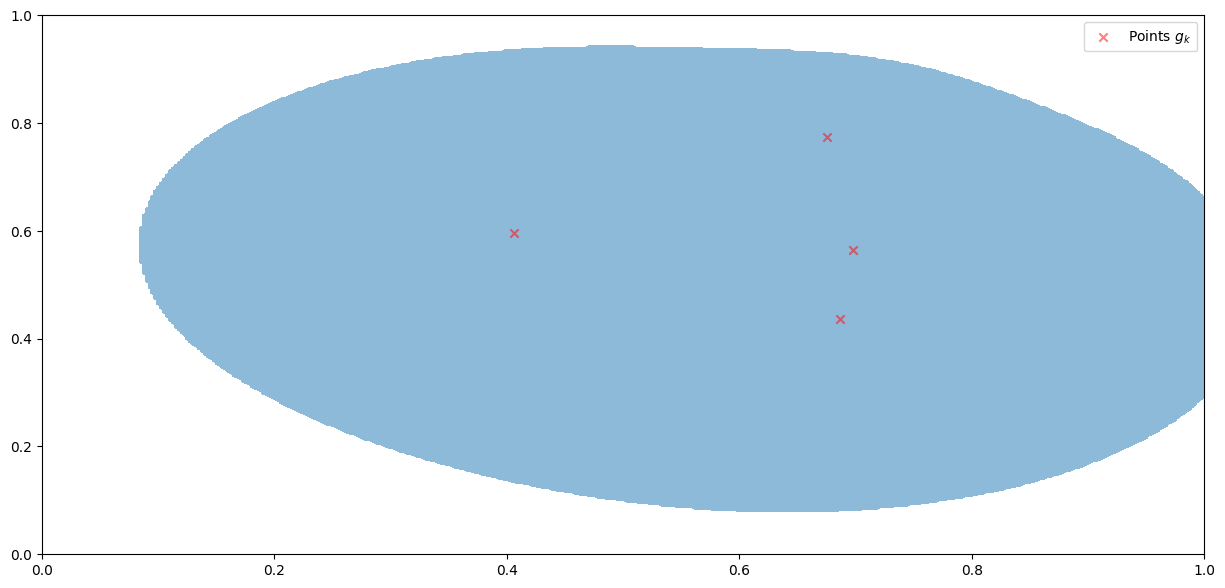

In [225]:
# Réalisation d'un ensemble A
plt.figure(figsize = (15, 7))

g, s = ensalea(4, 0.3, 1)

plt.show()

Affichage de B :
 [[0. 0. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0.]]

Affichage de B collant au graphe (rotation par 90° sens anti-horaire de la matrice) :
 [[0. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1.]
 [0. 1. 0. 0. 0.]]

Erreur empirique de Rp sur les données d'apprentissage : 0.09
Affichage du R_test du modèle : 0.208


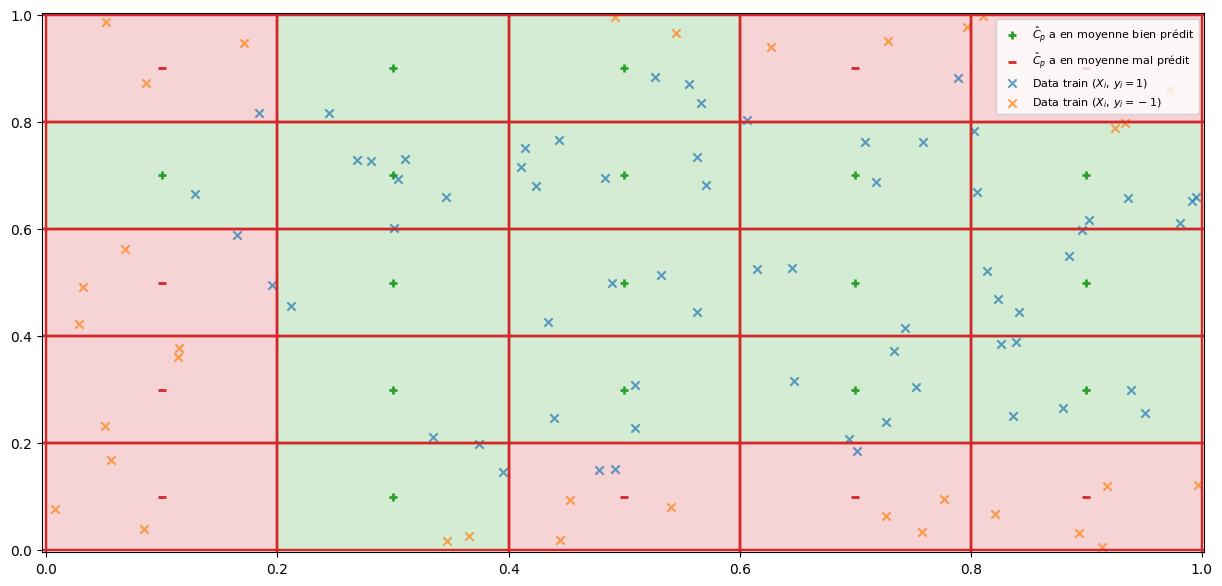

In [274]:
plt.figure(figsize = (15, 7))

l : int = 100 # Taille de l'échantillon
p : int = 5 # Nombre de cellules
m : int = 5000 # Taille d'échantillon de test

X, Y = echant(l, g, s) # Création d'un échantillon de taille l pour un apprentissage

X1 : ArrayLike = X[:,0] # Ensemble des x_i
X2 : ArrayLike = X[:,1] # Ensemble des y_i

B, Re = estens(X1, X2, Y, p) # Création de B qui participe à la construction de l'estimateur/modèle Cp
plot_B(B) # Affichage de B

Risque_emp : float = testens(B, m, g, s) # Calcul du risque empirique pour l'estimateur Cp chapeau
plot_echant(X, Y) # Affichage des points X qui sont des croix bleux si y_i = 1 et orange sinon 

print("Affichage de B :\n", B)
print("\nAffichage de B collant au graphe (rotation par 90° sens anti-horaire de la matrice) :\n", np.rot90(B))
print("\nErreur empirique de Rp sur les données d'apprentissage :", Re)
print("Affichage du R_test du modèle :", Risque_emp)

plt.show()

Pour l = 100, le p optimal vaut : 4
Pour l = 500, le p optimal vaut : 11
Pour l = 1000, le p optimal vaut : 11
Pour l = 10000, le p optimal vaut : 41


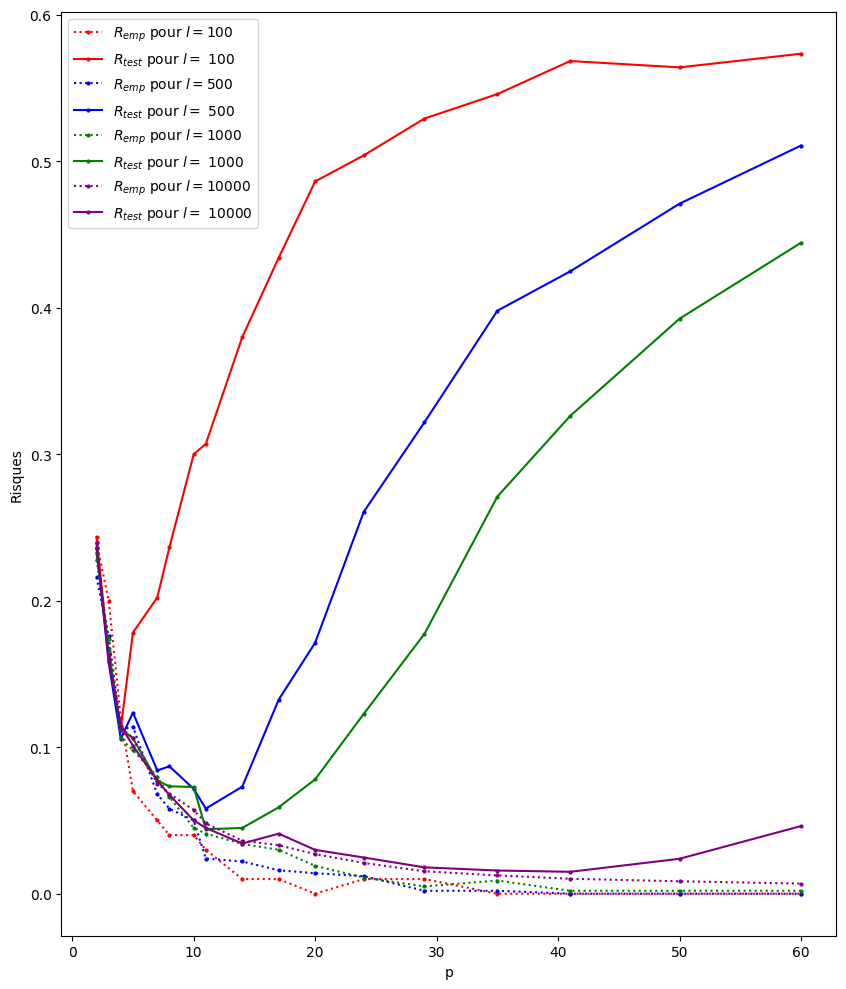

In [382]:
plt.figure(figsize = (10, 12))

L_liste : list[int] = [100, 500, 1_000, 10_000]
p_liste : ArrayLike = np.sort(list(set( int(k) for k in np.logspace(np.log10(2), np.log10(60), 20) )))

eta : float = 0.05
epsilon : float = 0.02

m : int = int(- np.log(eta/2) / (2 * epsilon**2)) + 1

color_list : list[str] = ['red', 'blue', 'green', 'purple']
g, s = ensalea(4, 0.3, 0)

for k in numba.prange(len(L_liste)):
    R_emp_liste : list[float] = []
    R_test_liste : list[float] = []

    X, Y = echant(L_liste[k], g, s)
    
    X1 : ArrayLike = X[:,0]
    X2 : ArrayLike = X[:,1]
    
    for p in p_liste:
        B, R_emp = estens(X1, X2, Y, p)
        R_test = testens(B, m, g, s)

        R_emp_liste.append(R_emp)
        R_test_liste.append(R_test)
        
    plt.plot(p_liste, R_emp_liste, linestyle = 'dotted', label = r'$R_{emp}$ pour $l = $' + str(L_liste[k]), color = color_list[k], marker = 'o', linewidth = 1.5, markersize = 2)
    plt.plot(p_liste, R_test_liste, label = r'$R_{test}$ pour $l = $ ' + str(L_liste[k]), color = color_list[k], marker = 'o', linewidth = 1.5, markersize = 2)
    
    print("Pour l = %d, le p optimal vaut : %d" %(L_liste[k], p_liste[np.argmin(R_test_liste)]))
    
plt.xlabel('p')
plt.ylabel('Risques')
plt.legend()
plt.show()


- **Question 8 :** Commenter :
    - l'évolution des deux courbes à $l$ fixé, $p$ variant
        -   À $l$ fixé, plus $p$ est grand, plus on a de chance de faire de l'overfitting. Ceci se voit particulièrement quand on regarde $R_{test}(\hat{C}_{p})$ quand $p$ grandit. Concrètement, il existera des cellules où il n'y a pas de points et l'estimateur va préférer considérer ces cellules comme appartenant à l'ensemble $A$ (pour éviter l'overfitting), ce qui n'est pas forcément vrai et plus $p$ sera grand, plus nombreuses seront ces cellules.
    - l'évolution de $\hat{p}$ en fonction de $l$
        -   Plus $l$ est grand, plus $p$ grandit sans que la valeur de $p$ explose car l'information qu'on obtient sur l'ensemble $A$ est d'autant plus grande quand $l$ croît, et donc permet de correctement découper l'ensemble $A$.
    - l'évolution de $R_{test} (1_{\hat{C}_{\hat{p}}})$ en fonction de $l$, à $p$ fixé
        -   À $p$ fixé, plus $l$ est grand, plus l'erreur $R_{test} (1_{\hat{C}_{\hat{p}}})$ est petite. Ceci s'explique par le fait d'avoir assez de données qui décrivent l'ensemble $A$ et donc moins de chance d'overfit.
    
    En particulier, comment cette expérience illustre :
    - le compromis entre complexité des modèles et taille de l'échantillon d'apprentissage
        -   Lorsque $p$ augmente, on observe comme prévu de meilleures performances jusqu'à un certain $p = \hat{p}$, qui est la valeur pour laquelle on aura que $R_{emp}$ et $R_{test}$ petits. À partir de cette valeur, le modèle perfomera mal sur les données de test, car en complexifiant le modèle on passe sur un modèle qui fonctionne très bien sur les données d'entraînement, mais ne se generalise pas bien aux données de test.

            La valeur $\hat{p}$ représente le "sweet spot", c'est-à-dire que la complexité pour laquelle $R_{emp}$ soit petit mais que $R_{test}$ le soi aussi. On remarque que l’ajout de données d’entraînement est une méthode efficace pour résoudre le problème d’overfitting et permet de réduire la variance du modèle. Cela nous permet alors de chercher des modèles plus précis tout en maintenant une bonne généralisation aux données de test.

            Il faut trouver un bon compromis entre $p$ et $l$, car pour $l$ grand, il faudra aussi prendre $p$ grand pour obtenir un modèle précis. Lorsque $l$ est petit, on prend aussi un $p$ petit, car pour peu des données d'entraînement, il est inutile de complexifier le modèle sous peine de faire de l'overfitting.
    - la consistance de la minimisation du risque empirique sur la famille $\mathcal{F}_{p}$
        -   La consistance de la minimisation du risque empirique signifie que, lorsque la taille de l’échantillon d’entraînement $l$ augmente, la solution obtenue en minimisant $R_{emp}$ se rapproche de celle qui minimise le risque réel $R^{*}$.
            Dans cette expérience, cela se traduit par deux observations :
            1) Avec un $l$ fixé, le $\hat{p}$ optimal (minimisant $R_{test}$) montre que la minimisation du risque empirique sélectionne une complexité $p$ qui généralise bien aux données de test.
            2) Lorsque $l$ augmente, le $R_{test}$ pour ce $\hat{p}$ tend à diminuer, montrant que le $R_{emp}$ devient de plus en plus proche du vrai optimum.

            Cela illustre la consistance de la méthode, puisque l’écart entre $R_{emp} (\hat{C}_{\hat{p}})$ et $R_{test}(\hat{C}_{\hat{p}})$ se réduit avec un $l$ croissant.
